In [1]:
!pip install pandas numpy sklearn matplotlib tensorly openpyxl keras scipy tensorflow

In [1]:
##Here is the required python functions to run this notebook
##The main packages used are sklearn, tensorly, pandas, matplotlib and numpy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF
import tensorly as tl
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.integrate as integrate
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

Shape of the matrix (across timepoints):  (32000, 9)
Shape of matrix reshaped (across trials):  (640, 50, 9)
Shape of matrix (across muscles)


Text(0, 0.5, 'EMG amplitude')

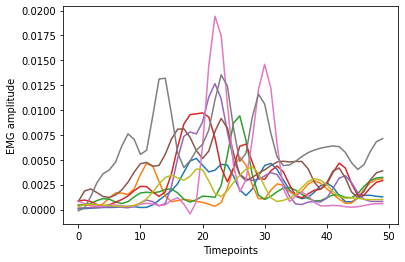

In [2]:
##Data preperation

#The first step in any analytical approach is to get to know your data. For this sample sheet, we are using a dataset 
#of nine EMG channels recorded across the right arm and torso during point-to-point backward and forwards reaching movements 
#(see https://doi.org/10.1152/jn.00245.2013 for details on the data collection). 
#In the following code, we will import this data for a single subject across 640 trials 
#(320 in the forward direction, 320 in the backwards direction) using the pandas package.

X=pd.read_excel(r'Machine_Learning_tutorials/EMG_daven1.xlsx')

#This matrix is formatted across time (i.e. rows=timepointsxtrials, columns=EMG channels)
#To find the dimensions of this matrix, simply add the following term at the end of the variable:

print('Shape of the matrix (across timepoints): ',X.shape)

#Inspect the data on a trial-to-trial basis by reshaping the 2D matrix into a 3D tensor. Each trial consists of 50
#timepoints, therefore we need to produce a 640 trial x 50 timepoint x 9 muscle tensor in the following way:

X_tensor=X.values.reshape(640,50,9)
print('Shape of matrix reshaped (across trials): ',X_tensor.shape)

#We can also reshape this tensor back to a 2D matrix but across muscles instead of across time
#We do so by swapping the axes in the above tensor so that timepoints are along the first dimension and then
#converting the tensor back to a 2D matrix as shown below:

X_Temporal=X_tensor.transpose(1,0,2).reshape(50,640*9)
print('Shape of matrix (across muscles)')

#Here you can plot a single trial to inspect the quality and interpretability of the EMG recordings 
#using the matplotlib library:
trial=10
plt.plot(X_tensor[trial,:,:])
plt.xlabel('Timepoints')
plt.ylabel('EMG amplitude')

#Can you plot the across timepoints and across muscles matrices below?


#Can you plot just a specific timepoint/muscle from these matrices also?




In [22]:
#It is important when interpreting the data that it is put in the context of the motor behavior being performed.
#So now we will import three task variables that categorise the above data based on the following events:
    #TASK = All reaching movements in both directions and at fast and slow speeds.
        #(1-4= forward reaching at a slow speed, 5-8= backward reaching at a slow speed, 9-12=forward reaching at a fast pace,
        #13-16= backward reaching at a fast pace
    #Speed = Fast or slow reaching speeds.
    #Direction = Forward or backwards direction

Y=pd.read_excel('Machine_Learning_tutorials/trg.xlsx')


task=Y.iloc[:,1]

Fast trials in the backward reaching direction selected...
Muscles included:  ['BR', 'BI', 'TM']
Averaging across Timepoints


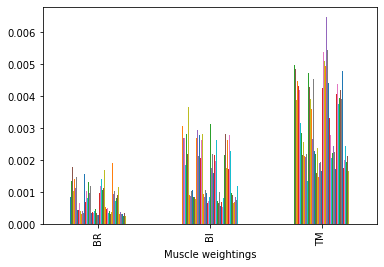

In [4]:
#The following function extracts reaching task trials in a specific direction and at a specific speed. Along with this
#you can extract specific EMG channels and conduct an averaging either across trials or across timepoints

#Here are the input variables for the function

    #Speed: 1 for fast and 0 for slow speed
    #Direction: 0 for forward and 1 for backward reaching direction
    #Muscle: integers ranging from [1-9] for the following muscles respectively: 
        #[Finger extensor, brachioradialis, biceps brachii,triceps medialis, triceps lateralis, anterior deltoid, posterior deltoid, pectoralis major, latissimus dorsi].
    #Average: 0=Across trials, 1=Across Timepoints

def func_data(Speed, Direction,Muscle, Average):
    

    #Conditional indexing of the EMG matrix in tensor formate for specific speed and direction trials
    if Speed==0 and Direction==0:
        trial=X_tensor[np.where((Y['Speed']==0) & (Y['Direction']==0))]
        print('Fast trials in the forward reaching direction selected..')
    elif Speed==1 and Direction==0:
        trial=X_tensor[np.where((Y['Speed']==1) & (Y['Direction']==0))]
        print('Slow trials in the forward reaching direction selected...')
    elif Speed==0 and Direction==1:
        trial=X_tensor[np.where((Y['Speed']==0) & (Y['Direction']==1))]
        print('Fast trials in the backward reaching direction selected...')
    else:
        trial=X_tensor[np.where((Y['Speed']==1) & (Y['Direction']==1))]
        print('Slow trials in the backward reaching direction selected...')
    
    
    #What muscles have been selected
    print('Muscles included: ', X.columns[Muscle].tolist())
    
    #Extract the muscles of interest
    trial=trial[:,:,Muscle]
    
    
    if Average==0:
        trial=trial.mean(axis=0)
    elif Average==1:
        trial=trial.mean(axis=1)
        
    if Average==0:
        print('Averaging across trials')
        plt.xlabel('Timepoints')
        plt.plot(trial)
    elif Average==1:
            print('Averaging across Timepoints')
            pd.DataFrame(trial.T).plot(kind='bar',legend=False).set_xticklabels(X.columns[Muscle])
            plt.xlabel('Muscle weightings')
        

    
#Adjust the below input values to view different outputs   

func_data(Speed=0,Direction=1,Muscle=[1,2,3],Average=1)

In [244]:
#Inspect the function above and see if you can you get the trial-averaged data for a specific timepoint?
    #Hint: To index all the timepoints and muscles in a specific trial of a 3D matrix, you must index like '[x,:,:]'



    
#Examine the code in the function above and see if you can find the time-averaged data for a specific timepoint?



#How can you confirm the shape of the reshaped matrix? Show this below..




In [5]:
#Next, we need to specify the number of components we wish to extract during the dimensionality reduction process. This
#step is vital as too few or too many extracted components gives a suboptimal representation of the original matrix. The
#appropriate model-rank is notoriously difficult to empirically determine (see doi: 10.1007/s00421-021-04604-9 for details),
#and so here we will start with an arbitrary number of your choice and demonstrate an empirical method later on....

##Specify the model rank you want to investigate using this variable:
num_components=3


Input matrix shape:  (32000, 9)


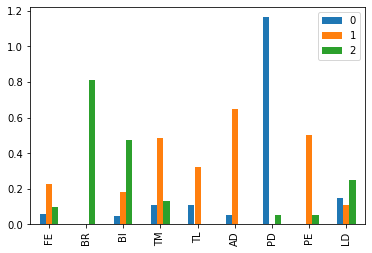

Timepoint specific activation coefficient : [[0.00088838 0.00170997 0.00179568 ... 0.00066862 0.00071824 0.00073111]
 [0.0009906  0.00104601 0.0015279  ... 0.0005921  0.00051198 0.00050004]
 [0.0002923  0.00031744 0.00037155 ... 0.00063501 0.00053203 0.00051964]]


In [6]:
##Non-negative matrix factorisation
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

#NMF is a matrix factorisation method implemented on 2D matrices. We will therefore input a matrix with the following
#dimensions:
print('Input matrix shape: ',X.shape)


model_NMF=NMF(n_components=num_components,solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False)

    #Below is an implementation of NNMF in the spatial domain (i.e. relative weightings in muscle activity across time)





W_spatial = model_NMF.fit_transform(abs(X).T)
H_spatial = model_NMF.components_

pd.DataFrame(W_spatial).plot(kind='bar').set_xticklabels(X.columns)
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)



#We can also investigate the predominant patterns in the temporal domain (i.e. covariation in EMG activity across muscles).
#The data first needs to be manipulated so as to capture this across muscle dimension...
#This involves the reshaping discussed earlier...Can you implement this in the space below?






##Here are the hyperparameters for NNMF that you can adjust, press shift+tab while inside the function to see the options
##in detail

# 'init': The method to initialise the extracted components
# 'solver': Numerical solver to use for the optimisation problem
# 'beta_loss': the loss function
# 'tol': the Tolerance of the stopping criterion
# 'max_iter': Maximum number of iterations during timing out
# 'alpha': a constant that adjust the influence of the regularisations terms in the loss function
# 'l1_ratio': a mixing parameter that allows one to adjust the regularisation term towards either L1 or L2 penaly terms


##What is the effect of adjusting each of these hyperparameters on the output???




Explained variance ratio:  [0.67431104 0.12472403 0.06181461]
Singular values:  [1.21993192 0.52466311 0.36936099]


[Text(0, 0, 'FE'),
 Text(1, 0, 'BR'),
 Text(2, 0, 'BI'),
 Text(3, 0, 'TM'),
 Text(4, 0, 'TL'),
 Text(5, 0, 'AD'),
 Text(6, 0, 'PD'),
 Text(7, 0, 'PE'),
 Text(8, 0, 'LD')]

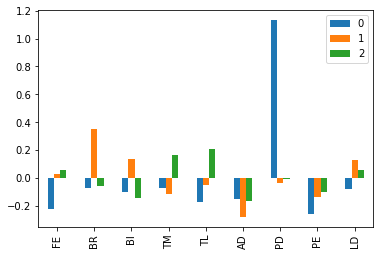

In [7]:
## Principal component analysis
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


##Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on PCA...

model_pca=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model_pca.fit(X.T)
print('Explained variance ratio: ',model_pca.explained_variance_ratio_)
print('Singular values: ', model_pca.singular_values_)

X_pca=model_pca.transform(X.T)

pd.DataFrame(X_pca).plot(kind='bar').set_xticklabels(X.columns)

Components:  [[-0.00080731 -0.00113351 -0.0012396  ...  0.00079579  0.00056558
   0.00053642]
 [-0.00059061 -0.0012483  -0.00135354 ... -0.00014202 -0.0002212
  -0.00023548]
 [ 0.00344913  0.00362457  0.00582198 ...  0.00211535  0.00120819
   0.00106807]]
Mixing values:  [[-0.00023332 -0.00062975  0.00051723]
 [-0.00019052 -0.00150236  0.00054629]
 [-0.00027363 -0.00160592  0.00086502]
 ...
 [ 0.00021004 -0.00036417  0.00027612]
 [ 0.00018678 -0.00043564  0.00015243]
 [ 0.00018566 -0.00045111  0.00013309]]
Mean values:  [0.00050279 0.0006661  0.00075432 ... 0.00043614 0.00040884 0.00040652]


[Text(0, 0, 'FE'),
 Text(1, 0, 'BR'),
 Text(2, 0, 'BI'),
 Text(3, 0, 'TM'),
 Text(4, 0, 'TL'),
 Text(5, 0, 'AD'),
 Text(6, 0, 'PD'),
 Text(7, 0, 'PE'),
 Text(8, 0, 'LD')]

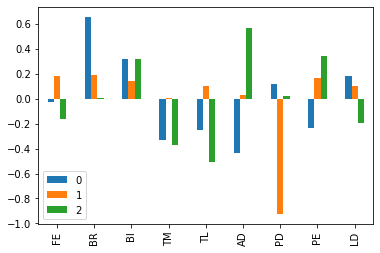

In [8]:
#Independent component analysis
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

##Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on ICA...

model_ica=FastICA(n_components=num_components, algorithm='parallel', whiten=True, 
        fun='logcosh', fun_args=None, max_iter=200, 
        tol=0.0001, w_init=None, random_state=None)
model_ica.fit(X.T)
print('Components: ',model_ica.components_)
print('Mixing values: ', model_ica.mixing_)
print('Mean values: ', model_ica.mean_)

X_ica=model_ica.transform(X.T)

pd.DataFrame(X_ica).plot(kind='bar').set_xticklabels(X.columns)

PARAFAC output structure:  (weights, factors) : rank-3 CPTensor of shape (640, 50, 9) 


<AxesSubplot:>

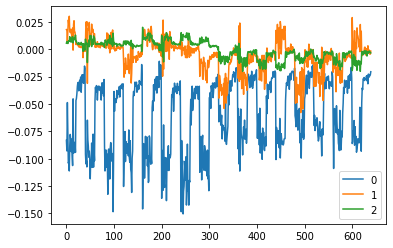

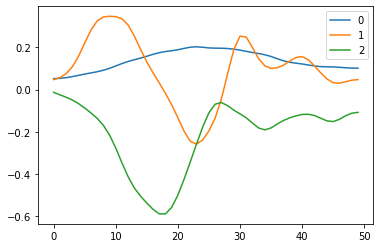

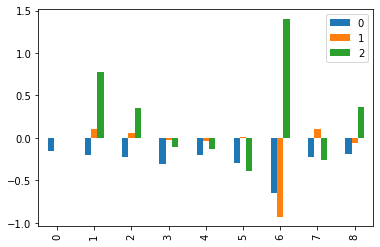

In [9]:
##Tensor decompositions: PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a different tensor decomposition method known as PARAFAC or Canonical Decomposition

#As before, we begin with a tensor, we also need to set it to a data type specific to the Tensorly package as shown below:
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Using a function provided by the Tensorly package, we implement the PARAFAC decomposition at a model-rank
#equal to the value contained by the num_components variable
factors_para = parafac(X_tensor ,rank=num_components)

#The output is a structure holding the following arrays:
print('PARAFAC output structure: ', factors_para)

#To index the substructures of this PARAFAC decomposition, you can do so in the following manner:

factors_para[0]   #Weights (Note. these are all equal to 1, see the user guide to adjust the weighting of each dimension) 
factors_para[1]   #Factors

#The factors sub-structure is of particular interest here as it contains the low-dimensional representations of the original
#dataset across trials, across timepoints and across muscles
#You
pd.DataFrame(factors_para[1][0]).plot()
pd.DataFrame(factors_para[1][1]).plot()
pd.DataFrame(factors_para[1][2]).plot(kind='bar')

<AxesSubplot:>

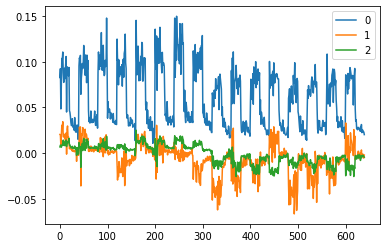

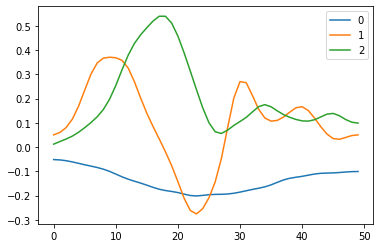

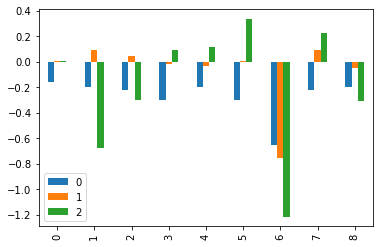

In [10]:
##Tensor decompositions: Orthogonal-PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a PARAFAC decomposition that is orthogonally constrained:

#As before, we begin with a tensor, we also need to set it to a data type specific to the Tensorly package as shown below:
X_tensor=tl.tensor(X.values.reshape(640,50,9))


#Using a function provided by the Tensorly package, we implement the Orthogonal PARAFAC decomposition:
factors_orthpara = parafac(X_tensor ,rank=num_components,orthogonalise=True)

#Can you index into this decompositions output and extract the factors?, refer to the user guide for help


#What differences are there with the previous PARAFAC output?
pd.DataFrame(factors_orthpara[1][0]).plot()
pd.DataFrame(factors_orthpara[1][1]).plot()
pd.DataFrame(factors_orthpara[1][2]).plot(kind='bar')



In [11]:
##Tensor decompositions: Tucker decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Lets input the EMG data across all trials, timepoints and muscles as a tensor into a Tucker decomposition.

#Firstly we reshape the data into 3 dimensions
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Then using the Tensorly package, use this tensor as input in the following manner:

core, factors_tuck = tucker(X_tensor ,rank=[num_components,num_components,num_components])

#This results in two outputs, a core and an array of factors. The factors are what we are interested in here as they
#represent the spatial, temporal and trial specific components of the original dataset

#We can also vary the number of the individual components we extract as shown below:

cores, factors = tucker(X_tensor ,rank=[3,3,4])

#To index into the factors array and find the components of interest, you can do so in the following manner:

factors[0]    #Trial-specific components
factors[1]    #Temporal components
factors[2]    #Spatial components


#Can you plot the output as shown above for PARAFAC??



array([[-0.14465037,  0.17749551, -0.08203785, -0.2343567 ],
       [-0.227388  , -0.16095729, -0.72630583,  0.4038589 ],
       [-0.22773006,  0.07872349, -0.52219189, -0.5913106 ],
       [-0.27933257,  0.37300762,  0.05776987, -0.27230344],
       [-0.18072017,  0.26823897,  0.1506466 , -0.25854062],
       [-0.25327658,  0.55426577,  0.12642469,  0.47913082],
       [-0.78990416, -0.47369517,  0.34188487,  0.0119267 ],
       [-0.1780384 ,  0.43968356, -0.07868313,  0.1545802 ],
       [-0.21219862, -0.01961097, -0.16725433,  0.1942438 ]])

In [12]:
##Tensor decompositions: Non-negative Tucker
##http://tensorly.org/stable/user_guide/tensor_decomposition.html


#Try to replicate the above computation on a Tucker decomposition with non-negative constraints.

X_tensor=tl.tensor(X.values.reshape(640,50,9))
core, factors_nnt =non_negative_tucker(X_tensor ,rank=[num_components,num_components,num_components])


#What effect does this non-negativity have on the interpretability of the output??



LDA Accuracy score:  0.9791666666666666


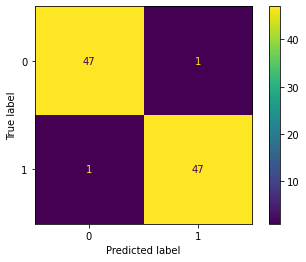

In [23]:
## Decode the task variable you selected using the underlying parameters trial-specific coefficients 
#from the above tensor decompositions
## For the Task1-16 variable, a decoding accuracy >1/16 is significant and so on for the other variables.
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008

#Here is an example implementation using Linear discriminant analysis on the Tucker decomposition output

#Split the trial-specific activation coefficients and the task variable into training and testing groups as follows:

X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],task,train_size=0.85,stratify=task)

#Adjust the training size above to whatever percentage you see fit...

#Initialise the LDA model
model=LDA()
#Fit the training data to the model
model.fit(X_train,y_train)

#Use the fitted model to task category of the unseen test data
y_pred=model.predict(X_test)
#Determine the accuracy score by constrasting the predictions against the actual task output
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_tuck=accuracy_score(y_test,y_pred)

#Plot a confusion matrix to show the true/false positives and negatives
plot_confusion_matrix(model,X_test,y_test)

#Always put the following statement at the end of a piece of code with plots 
plt.show()



##Now carry out the above using the trial-specific components from different tensor decompositions

##Once you have done that, try the same using different classifiers, for example:

    #Naive-Bayes
    #https://scikit-learn.org/stable/modules/naive_bayes.html

    ##K-Nearest Neighbors
    ##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

In [310]:
##Can you find the tensor decomposition model that gives the best output in terms of the VAF vs Task-decoding trade-off??





##Create a for loop that iterates from the model ranks 1-10 as the input parameter for each tensor decomposition and compute
#the VAF and task discrimination accuracy for all.





#Get both the VAF and Accuracy score for the presented tensor decompositions and compare them in terms of this trade-off..
#Read through the following paper on how you can get a summary statistic to represent this trade-off





In [17]:
##Deep learning##

##Below you can find the code setup for a multi-layer perceptron (MLP_, the simplest form of neural network.
##Who's output layer is applicable to classification problems


##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##3 for PARAFAC and 4 for Orthogonal PARAFAC. Note that the MLP is sensitive to the magnitude of the input variables 
#and therefore it is necessary to standardise them


##Look across the web for a general rule for how many layers and nodes one should have in a neural network and see if it
##produces the best results here.


Type=4

if Type==1:
    X_mlp=factors_tuck[0]
elif Type==2:
    X_mlp=factors_nnt[0]
elif Type==3:
    X_mlp=factors_para[1][0]
else:
    X_mlp=factors_orthpara[1][0]



#Split the data into training and testing groups
X_train, X_test, y_train, y_test=train_test_split(X_mlp,task.values,train_size=0.85)

#Initialise the standardiser and fit it to the data as follows:
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Initialise the MLP and fit the training data
clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(75,25), random_state=1)

clf.fit(X_train, y_train)

#Make predictions and check the accuracy
y_preds=clf.predict(X_test)
print('MLP Accuracy score: ',accuracy_score(y_test,y_preds))
plot_confusion_matrix(clf ,X_test,y_test)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [318]:
##Try to construct your own neural network that can classify the right reaching task...here is an example using the Keras framework
##https://keras.io/

##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##and 3 for PARAFAC. Note that the neural network is sensitive to the magnitude of the input variables and therefore it is necessary to
##standardise them

Type=4

if Type==1:
    X_NN=factors_tuck[0]
elif Type==2:
    X_NN=factors_nnt[0]
elif Type==3:
    X_NN=factors_para[1][0]
else:
    X_NN=factors_orthpara[1][0]

    
##This neural network cannot take multiple classes as a target variable, therefore we must encode the target variable
##as a set of binary integers
# encode class values as integers


if task.name=='Task':
    encoder = LabelEncoder()
    encoder.fit(task)
    encoded_Y = encoder.transform(task)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    X_train, X_test, y_train, y_test=train_test_split(X_NN,dummy_y,train_size=0.85)
else:
    X_train, X_test, y_train, y_test=train_test_split(X_NN,task.values,train_size=0.85)
    
##As with the MLP above, the neural network is sensitive to differences in magnitude between predictor variables that may not
##necessarily be informative...therefore we will scale the input data accordingly
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)





##Here are some parameters you can adjust to optimise the neural network, how do these adjustments effect the output??:

#The number of neurons in the layer
#The number of layers
#The activation function
#The loss function
#The optimizer
#The metrics
#The training epochs
#The batch size
#The number of cross-validations




def NeuralNet_model():
# create model
    model = Sequential()
    model.add(Dense(50, input_dim=num_components, activation='relu'))
    #Add another network layer here:
    #model.add(Dense(50, input_dim=num_components, activation='relu'))
    
    #The final layer has a softmax activation function so as to give a single value estimate
    model.add(Dense(np.unique(task)[-1], activation='softmax'))
    
# Compile model
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train,y_train)
    return model

#Cross-validate the results
estimator = KerasClassifier(build_fn=NeuralNet_model, epochs=200, batch_size=1, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_test, y_test, cv=kfold)
print("Cross validated score (Mean (Std)): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

17/17 [==============================] - 0s 877us/step - loss: 0.0000e+00 - accuracy: 0.4370


17/17 [==============================] - 0s 939us/step - loss: 0.0000e+00 - accuracy: 0.5390


17/17 [==============================] - 0s 931us/step - loss: 0.0000e+00 - accuracy: 0.5019


17/17 [==============================] - 0s 812us/step - loss: 0.0000e+00 - accuracy: 0.5006


Cross validated score (Mean (Std)): 53.16% (4.21%)
